<a href="https://colab.research.google.com/github/danoliver1792/machine_learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Treinando uma rede neural para classificar imagens de cães x gatos

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

I - Iremos importar o OS para manipular os arquivos de diretórios;
II - Importaremos o Numpy para cálculos de matrizes fora do TensorFlow;
III - E o Matplotlib.pyplot para plotar gráficos e exibir imagens em nossos dados de treinamento e validação.

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Baixando as imagens Dogs vs. Cats do Kaggle pela URL e descompactando no sistema de arquivos do Colab.

In [7]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68606236/68606236 [==============================] - 0s 0us/step


In [9]:
# listando os diretórios:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


Atribuindo variáveis com o caminho adequado para os conjuntos de treinamento e validação.

In [10]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# diretorio com as imagens de treinamento dos gatos
train_cats_dir = os.path.join(train_dir, 'cats')
# diretorio com as imagens de treinamento dos cães
train_dogs_dir = os.path.join(train_dir, 'dogs')

# diretorio com a validação das fotos de gatos
validation_cats_dir = os.path.join(validation_dir, 'cats')
# diretorio com a validação das fotos de cães
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Verificando a quantidade de imagens de gatos e cães que temos no nosso treinamento e validação.

In [11]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [12]:
print('Total de treinamento das imagens de gatos: ', num_cats_tr)
print('Total de treinamento das imagens de caes: ', num_dogs_tr)

print('Total de validacoes das imagens de gatos: ', num_cats_val)
print('Total de validacoes das imagens de caes: ', num_dogs_val)

print('-' * 10)

print('Total de treinamentos: ', total_train)
print('Total de validacoes: ', total_val)

Total de treinamento das imagens de gatos:  1000
Total de treinamento das imagens de caes:  1000
Total de validacoes das imagens de gatos:  500
Total de validacoes das imagens de caes:  500
----------
Total de treinamentos:  2000
Total de validacoes:  1000


Configuração do limite de imagens durante o pré-processamento do nosso conjunto de dados e treinamento da rede.

In [13]:
# numero de exemplos de treinamento para processar
# antes das variaveis de modelos
BATCH_SIZE = 100

# processando dados com imagens de 150px x 150px (largura x altura)
IMG_SHAPE = 150

Preparando os dados.

Etapas:

1. Ler imagens do disco;

2. Decodificar o conteúdo das imagens e converter-los no formato de grade adequado de acordo com o RGB;

3. Converter em tensores de ponto flutuante;

4. Redimensionar os tensores de valores entre 0 e 255 para valores entre 0 e 1, porque as redes neurais preferem lidar com pequenos valores de entrada.

Para isso, vamos usar a classe 
tf.keras.preprocessing.image.ImageDataGenerator

In [14]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

Após a definição dos nossos geradores para imagens de treinamento e validação, vamos carregar as imagens do disco, aplicando o redimensionamento usando uma única linha de código.

In [15]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, directory=train_dir, shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE), class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [16]:
val_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, directory=validation_dir, shuffle=False,
    target_size=(IMG_SHAPE, IMG_SHAPE), class_mode='binary'
)

Found 1000 images belonging to 2 classes.


Visualizando imagens de treinamento.

In [17]:
sample_training_images, _ = next(train_data_gen)

A função abaixo plotará imagens na forma de uma grade com 1 linha e 5 colunas onde as imagens são colocadas em cada coluna.

In [18]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()
  

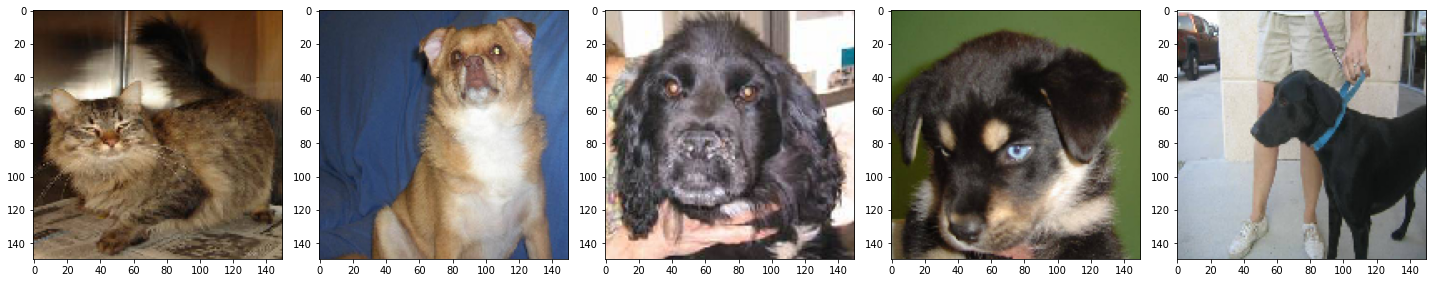

In [19]:
plotImages(sample_training_images[:5])

Criando o modelo.

O modelo consiste em quatro blocos de convolução com uma camada de pool máximo em cada um deles. Então temos uma camada totalmente conectada com 512 unidades, com um *relu* - função de ativação. O modelo produzirá probabilidades de classe para duas classes - cães e gatos - usando *softmax*

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

Compilando o modelo.

Usaremos o *adam* para otimização. Usaremos sparse_categorical_crossentropy como a função de perda. Também vamos observar a precisão do treinamento e da validação em cada época à medida que treinamos nossa rede, portanto, estamos passando o argumento das métricas.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Resumo do modelo.

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Treinando o modelo

Como nossos lotes vêm de um gerador (*ImageDataGenerator*), iremos usar *fit_generator* em vez de *fit*

In [ ]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

<ipython-input-24-d70e0a339f06>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
20/20 [==============================] - 115s 6s/step - loss: 0.7518 - accuracy: 0.5085 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 107s 5s/step - loss: 0.6911 - accuracy: 0.5125 - val_loss: 0.6846 - val_accuracy: 0.5310
Epoch 3/100
20/20 [==============================] - 107s 5s/step - loss: 0.6887 - accuracy: 0.5560 - val_loss: 0.6907 - val_accuracy: 0.5010
Epoch 4/100
20/20 [==============================] - 112s 6s/step - loss: 0.6900 - accuracy: 0.5265 - val_loss: 0.6844 - val_accuracy: 0.5710
Epoch 5/100
20/20 [==============================] - 111s 6s/step - loss: 0.6859 - accuracy: 0.5175 - val_loss: 0.6825 - val_accuracy: 0.5600
Epoch 6/100
20/20 [==============================] - 105s 5s/step - loss: 0.6809 - accuracy: 0.5535 - val_loss: 0.6871 - val_accuracy: 0.5310
Epoch 7/100
20/20 [==============================] - 113s 6s/step - loss: 0.6745 - accuracy: 0.5725 - val_loss: 0.7015 - val_accuracy: 0.5430
Epoch 